In this notebook, we just make sure we can replicate our results using our newly implemented ELO class...

In [1]:
from fetch.match_results import read_joined 

df, player_mapping, inverse_player_mapping = read_joined()

/Users/siddhantjagadish/Documents/DataProjects/tennis_modeling/tennis_modeling/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [2]:
df.sort_values(by=['date', 'round'], inplace=True)

#### True ELO Model

$\theta_{j, t + 1} = \theta_t + \alpha_{j, t}(y_t - \hat{y}_t)x_j$

From 538, one setting that works well is: 

$\alpha_{j, t} = \frac{250}{[M_{j, t} + 5]^{0.4}}$

Where $M_{j, t}$ is the number of matches player $j$ has played up to time $t$.

Is this particular to using baseline of $\theta=1500$?

Text(0.5,1,'Strength of Update over Time')

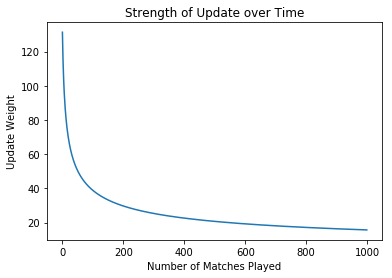

In [3]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np

# Plot alpha over time
_x = np.arange(1000)
_y = 250. / ((_x + 5) ** 0.4)
plt.plot(_x, _y)
plt.xlabel("Number of Matches Played")
plt.ylabel("Update Weight")
plt.title("Strength of Update over Time")

In [4]:
# For fair comparison to refitting + fatigue, remove dates before fatigue features populated.
import pandas as pd

df.drop(
    df[df['date'] < pd.to_datetime('2000-01-01')].index,
    inplace=True
)

In [5]:
import pandas as pd
import numpy as np
from collections import defaultdict
from models.elo import EloModel

# Tuned surface weights from before 
# TODO: Retune...
SURFACE_WEIGHTS = {
    'Clay': 1.0,
    'Hard': 0.4,
    'Grass': 0.0,
    'Indoor': 0.6
}
def process_row(mod, row, beta_history, preds, weight_fn=None):
    p1 = row['p1_idx']
    p2 = row['p2_idx']

    match_id = row['match_id']        
    pred = mod.predict(p1, p2) 
    preds.append((match_id, pred))

    if weight_fn is None:
        weight = SURFACE_WEIGHTS[row['__surface__']]
    else:
        weight = weight_fn(row)
    mod.update(p1, p2, row['y'], weight, match_id)
    beta_history.append((match_id, mod.beta[p1], mod.beta[p2]))
    return beta_history, preds 
    
def elo_backfill(df, c=250., o=5., s=0.4, weight_fn=None):
    mod = EloModel()
    beta_history = []
    preds = []
    for _, row in df.iterrows():
        beta_history, preds = process_row(
            mod,
            row,
            beta_history,
            preds,
            weight_fn=weight_fn
        )
    return beta_history, preds

In [6]:
beta_history, preds = elo_backfill(df, weight_fn=lambda row: SURFACE_WEIGHTS[row['__surface__']])

In [7]:
df['pred'] = zip(*preds)[1]

In [8]:
MIN_TEST_DATE = '2015-01-01'
MAX_TEST_DATE = '2017-01-01'

def _get_test_df(df, min_date, max_date, best_of=None):
    _temp = df[
        (df['date'] >= min_date) &
        (df['date'] < max_date) &
        (df['__surface__'] == 'Clay') &
        (~df['comment'].isin(['Retired', 'Walkover']))  # Remove retire from test set
    ]
    if best_of is None:
        return _temp
    else:
        return _temp[_temp['best of'] == best_of]

In [9]:
from sklearn.metrics import roc_auc_score

def compare_aucs(df):
    rel_df = df[df['p1_b365'].notnull()]
    return {
        "us": roc_auc_score(rel_df['y'], rel_df['pred']),
        "B365": roc_auc_score(rel_df['y'], 1. / rel_df['p1_b365'])
    }


In [10]:
rec_df = _get_test_df(df, MIN_TEST_DATE, MAX_TEST_DATE)
compare_aucs(rec_df)

{'B365': 0.79100821744627059, 'us': 0.76102547894583294}

In [11]:
roc_auc_score(rec_df['y'], rec_df['pred'])

0.76146226319930599

#### Look at players over time

In [ ]:
beta_history_df = pd.DataFrame(
    beta_history,
    columns=[
        'match_id',
        'p1_elo',
        'p2_elo'
    ]
)
history_df = pd.merge(df, beta_history_df, on='match_id', how='left')

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt


def plot_player(df, player_name):
    rel = df[
        (df['p1_name'] == player_name) |
        (df['p2_name'] == player_name)
    ]
    elo = rel['p1_elo'].copy()
    elo.loc[
        rel['p2_name'] == player_name
    ] = rel.loc[
        rel['p2_name'] == player_name,
        'p2_elo'
    ]
    plt.plot(rel['date'], elo)

In [ ]:
plot_player(history_df, "Nadal R.")
plot_player(history_df, "Federer R.")
plot_player(history_df, "Murray A.")
plot_player(history_df, "Djokovic N.")

This weighting works well, but above, it doesn't recognize the clear dominance of Rafa on clay vs. Federer's dominance on all other surfaces... 

#### Rescale Surface Weights

The way that I'm currently using surface weights, they also adjust the step-size -- for example, if the first matches in each year are on hardcourt, immediately followed by clay, then my time weights are also off?  This is weird?  The weighting scheme should govern *relative steps,* not absolute steps.  Here, keeping the same relative step-size, I tune the average weight as a parameter.

In [ ]:
surface_weights = df['__surface__'].map(lambda x: SURFACE_WEIGHTS[x]).mean()
ORIG_AVG_WEIGHT = surface_weights[surface_weights > 0].mean()  # Don't include 0's -- these aren't steps

def surface_weight_row(row, target_avg_weight): 
    return SURFACE_WEIGHTS[row['__surface__']] * (target_avg_weight / ORIG_AVG_WEIGHT)

In [ ]:
out = []
for scaler in np.linspace(0.1, 3.1, 31):
    print scaler
    target_avg_weight = ORIG_AVG_WEIGHT * scaler
    _, new_preds = elo_backfill(df, weight_fn=lambda x: surface_weight_row(x, target_avg_weight))
    df['__pred__'] = zip(*new_preds)[1]
    rec_df = _get_test_df(df, MIN_TEST_DATE, MAX_TEST_DATE)
    auc = roc_auc_score(rec_df['y'], rec_df['__pred__'])
    out.append((scaler, auc))

In [ ]:
out

#### Retune Relative Surface Weights

#### Tune 3-set and 5-Set Weights

Should make different predictions for 3-set and 5-set matches...should also be modeling probability of winning a set, rather than directly the probability of winning the match...

For now, try just sample weighting...

In [30]:
def set_weight_row(row, set_d):
    return set_d[row['best of']] * SURFACE_WEIGHTS[row['__surface__']]

rec_df = _get_test_df(df, MIN_TEST_DATE, MAX_TEST_DATE, best_of=3)
out = []

for sw in np.linspace(0., 1., 11):
    print sw
    _, new_preds = elo_backfill(df, weight_fn=lambda x: set_weight_row(x, {3: 1., 5: sw}))
    df['__pred__'] = zip(*new_preds)[1]
    rec_df = _get_test_df(df, MIN_TEST_DATE, MAX_TEST_DATE, best_of=3)
    auc = roc_auc_score(rec_df['y'], rec_df['__pred__'])
    out.append((sw, auc))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [31]:
out

[(0.0, 0.73827227254292282),
 (0.10000000000000001, 0.73875838105730041),
 (0.20000000000000001, 0.73919846746380802),
 (0.30000000000000004, 0.73951486945541456),
 (0.40000000000000002, 0.73990605737231019),
 (0.5, 0.73994057395321267),
 (0.60000000000000009, 0.74025409956307764),
 (0.70000000000000007, 0.74028861614398012),
 (0.80000000000000004, 0.74037778397797849),
 (0.90000000000000002, 0.74041230055888096),
 (1.0, 0.74027423423527083)]